# Building Intake-ESM datastores of ACCESS model output

This tutorial will demonstrate how users can build Intake-ESM datastores for their ACCESS model runs using the `access-nri-intake` Python package.

The ACCESS-NRI Intake Catalog consists of a set of intake-esm datastores, where a datastore has the result for one experiment. This tutorial focusses on <b>building one datastore for one experiment</b>. In general, it's assumed most user's wont build their own intake catalog, but could have several datastores for several experiments.

Note: The ACCESS-NRI Intake Catalog is curated by ACCESS-NRI with further information on its <a href="https://access-nri-intake-catalog.readthedocs.io/en/latest/index.html" target="_blank">documentation website</a> and <a href="https://access-hive.org.au/model_evaluation/model_evaluation_model_catalogs" target="_blank">this ACCESS-Hive page</a>. It contains a set of model output shared amongst the ACCESS-NRI working groups, including CMIP6 results and ACCESS-OM2 (as typically used in Cosima Recipes). 

----

A builder class is used for creating Intake-ESM datastores for each flavour of model output.  Classes for ACCESS model outputs are available in the `builders` submodule of the `access_nri_intake` Python package. 

In this tutorial, we'll build an Intake-ESM datastore for an ACCESS-CM2 model run with output at:

In [1]:
PATH = "/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6"

We can list the available builders:

In [2]:
from access_nri_intake.source import builders

dir(builders)[0:5]

['AccessCm2Builder',
 'AccessEsm15Builder',
 'AccessOm2Builder',
 'AccessOm3Builder',
 'BaseBuilder']

Because we're looking at ACCESS-OM2 output, we'll use the `AccessOm2Builder` class

# Building the datastore

Building the Intake-ESM catalog should be as simple as passing the model run base output directory to the Builder and calling `.build()`. The build is parallelized (without dask) so will be faster if you throw more resources at it. The following was run using an Large `normal` ARE instance (12 cpus).

In [3]:
%%time

builder = builders.AccessOm2Builder(
    path=PATH
).build()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/

CPU times: user 9.55 s, sys: 5.58 s, total: 15.1 s
Wall time: 2min 54s


The previous cell builds the Intake-ESM datastore in memory. We'll want to save it somewhere so we can reuse and share it. The following cell will create two new files (a `.json` and `.csv` file) in your current work directory. These files are how Intake-ESM datastores are stored on disk.

In [4]:
builder.save(
    name="mydatastore", 
    description="An example datastore for ACCESS-OM2 ryf9091",
)

Successfully wrote ESM catalog json file to: file:///home/603/as2285/mydatastore.json


# Using your datastore

Now we can use our Intake-ESM datastore to query and load the model data - see also the Intake-ESM documentation [here](https://intake-esm.readthedocs.io/en/stable/index.html).

We can load the datastore directly using `intake`.

In [5]:
import intake

esm_datastore = intake.open_esm_datastore(
    "./mydatastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

,unique
path,2013
realm,2
variable,319
frequency,4
start_date,855
end_date,854
variable_long_name,290
variable_standard_name,57
variable_cell_methods,6
variable_units,126


It's easy to search for datasets in the datastore containing a particular variable and load them as xarray Datasets. (Note for analysing large datasets, you may want to first start a dask cluster).

In [6]:
ds = esm_datastore.search(variable="temp", frequency="1mon").to_dask()

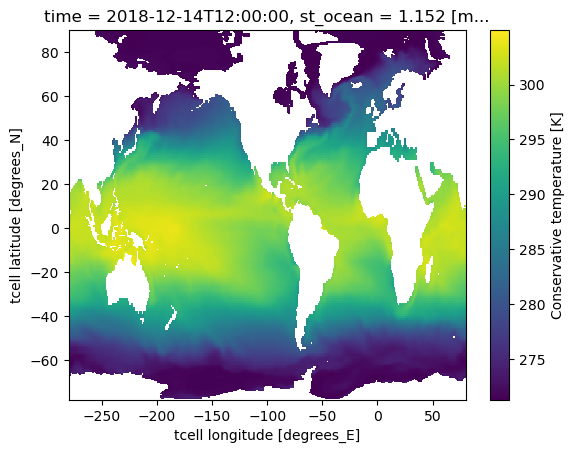

In [7]:
ds["temp"].isel(time=-1, st_ocean=0).plot()

If you think your ACCESS model data is worth sharing more widely, it might be a good idea to include it in the ACCESS-NRI Intake catalog. Please open an issue here to discuss: https://github.com/ACCESS-NRI/access-nri-intake-catalog/issues/new/choose